# Step 9: 2D Laplace Equation

Here is Laplace's equation in 2D:

$$
\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0
$$

We know how to discretize a 2nd order derivative. But think about this for a minute — Laplace's equation has the features typical of diffusion phenomena.
For this reason, it has to be discretized with *central differences*, so that the discretization is consistent with the physics we want to simulate. 

The discretized equation is:

$$
\frac{p_{i+1, j}^n - 2p_{i,j}^n + p_{i-1,j}^n}{\Delta x^2} + \frac{p_{i,j+1}^n - 2p_{i,j}^n + p_{i, j-1}^n}{\Delta y^2} = 0
$$

Notice that the Laplace Equation does not have a time dependence — there is no $p^{n+1}$.
Instead of tracking a wave through time (like in the previous steps), the Laplace equation calculates the equilibrium state of a system under the supplied boundary conditions.  

If you have taken coursework in Heat Transfer, you will recognize the Laplace Equation as the steady-state heat equation.  

Instead of calculating where the system will be at some time $t$, we will iteratively solve for $p_{i,j}^n$ until it meets a condition that we specify.
The system will reach equilibrium only as the number of iterations tends to $\infty$, but we can approximate the equilibrium state by iterating until the change between one iteration and the next is *very* small.  

Let's rearrange the discretized equation, solving for $p_{i,j}^n$:

$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n)+\Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)}$$

Using second-order central-difference schemes in both directions is the most widely applied method for the Laplace operator.
It is also known as the **five-point difference operator**, alluding to its stencil.

We are going to solve Laplace's equation numerically by assuming an initial state of $p=0$ everywhere. Then we add boundary conditions as follows:

$p=0$ at $x=0$

$p=y$ at $x=2$

$\frac{\partial p}{\partial y}=0\quad$ at $\quad y=0,\,1$

Under these conditions, there is an analytical solution for Laplace's equation:

$$p(x,y)=\frac{x}{4}-4\sum_{n=1,odd}^{\infty}\frac{1}{(n\pi)^2\, \sinh(2n\pi)}\sinh(n\pi x) \cos(n\pi y)$$

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.animation as anim

plt.rcParams["animation.html"] = "html5"
from matplotlib import cm


def plot3d(x, y, field, zlabel=None, zlim=None):
    fig, ax = plt.subplots(figsize=(11, 7), dpi=300, subplot_kw={"projection": "3d"})
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(
        X,
        Y,
        field,
        cmap=cm.coolwarm,
        rstride=1,
        cstride=1,
        antialiased=False,
        linewidth=0,
    )
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    if zlabel is not None:
        ax.set_zlabel(zlabel)
    if zlim is not None:
        ax.set_zlim(*zlim)
    ax.view_init(30, 225)
    # ax.set_box_aspect(aspect=None, zoom=0.8)
    plt.show()

In [2]:
# Solution parameter
x_domain_interval: tuple[int] = (0.0, 2.0)
y_domain_interval: tuple[int] = (0.0, 1.0)
nx: int = 31
ny: int = 31
c: float = 1.0
dx: float = x_domain_interval[1] / (nx - 1)
dy: float = y_domain_interval[1] / (ny - 1)

# Domain
x = np.linspace(*x_domain_interval, nx)
y = np.linspace(*y_domain_interval, ny)

# Grid of coordinate points
X, Y = np.meshgrid(x, y)

## Initial condition

In [3]:
# Initial conditions
p = np.zeros((ny, nx))

# Boundary conditions
p[:, 0] = 0.0  # p = 0 @ x = 0
p[:, -1] = y  # p = y @ x = 2
p[0, :] = p[1, :]  # dp/dy = 0 @ y = 0
p[-1, :] = p[-2, :]  # dp/dy = 0 @ y = 1

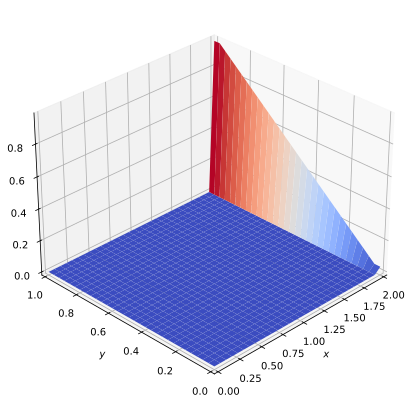

In [4]:
plot3d(x, y, p)

This is the initial state of our problem, where the value of `p` is zero everywhere except for along $x=2$ where $p=y$.

In [5]:
def laplace2d(p, y, dx, dy, l1norm_tolerance):
    """
    `laplace2d` takes five arguments, the `p` matrix, the `y`-vector, `dx`, `dy`
    and the value `l1norm_tolerance`.
    This last value defines how close the `p` matrix should be in two consecutive
    iterations before the loop breaks and returns the calculated `p` value.
    """
    l1norm = 1.0
    pn = np.empty_like(p)

    while l1norm > l1norm_tolerance:
        pn = p.copy()
        p[1:-1, 1:-1] = (
            dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2])
            + dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1])
        ) / (2 * (dx**2 + dy**2))

        p[:, 0] = 0  # p = 0 @ x = 0
        p[:, -1] = y  # p = y @ x = 2
        p[0, :] = p[1, :]  # dp/dy = 0 @ y = 0
        p[-1, :] = p[-2, :]  # dp/dy = 0 @ y = 1
        l1norm = np.sum(np.abs(p[:]) - np.abs(pn[:])) / np.sum(np.abs(pn[:]))

    return p

Now let's try to run our `laplace2d` function with a specified L1 tolerance of 0.01

In [6]:
p = laplace2d(p, y, dx, dy, 1e-4)

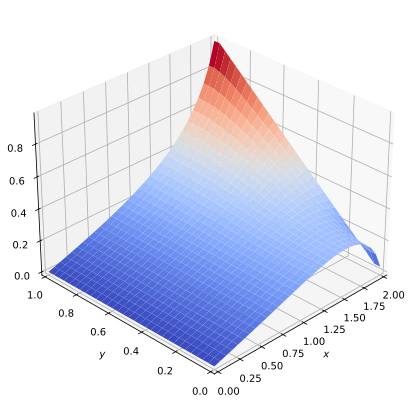

In [7]:
plot3d(x, y, p)